In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
with urllib.request.urlopen(url) as response:
    data = response.read().decode('utf-8')


## downloading the adult dataset

In [3]:
import pandas as pd

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data = pd.read_csv(data_url, header=None)

X_train = data.iloc[:, [0, 4, 10, 11, 12]].values
y_train = data.iloc[:, 14].values.astype(str)


In [4]:
np.unique(y_train)

array([' <=50K', ' >50K'], dtype='<U6')

In [5]:
X_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=",", skiprows=1)

y_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=",", skiprows=1)

y_test = np.array([a[:-1] for a in y_test])

In [6]:
np.unique(y_test)

array([' <=50K', ' >50K'], dtype='<U6')

## Logistic regression  with no privacy 

In [7]:
clf = LogisticRegression(solver="lbfgs")
clf.fit(X_train, y_train)

/Users/bhumitarora/anaconda3/envs/da204/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
baseline = clf.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 81.28%


## Adding privacy to data when fitting on logistic regression model

### taking epsilon = 0.01 

In [9]:
from privacyAdderLogistic import LogisticRegression
dp_clf = LogisticRegression(random_state=0,epsilon=0.01)
dp_clf.fit(X_train, y_train)

LogisticRegression(data_norm=99999.04562544584, epsilon=0.01, random_state=0)

In [10]:

print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=0.01): 21.74%


In [11]:
dp_clf = LogisticRegression(epsilon=float("inf"), data_norm=100)
dp_clf.fit(X_train, y_train)

LogisticRegression(data_norm=100, epsilon=inf)

In [12]:

print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=inf): 78.75%


In [13]:
print("Agreement between non-private and differentially private (epsilon=inf) classifiers: %.2f%%" % 
     (dp_clf.score(X_test, clf.predict(X_test)) * 100))

Agreement between non-private and differentially private (epsilon=inf) classifiers: 94.85%


In [14]:
from utils import check_random_state
from sklearn.metrics import precision_recall_fscore_support

accuracy = []
f_scores = []
epsilons = np.logspace(-3, 1, 50)
bounds = ([4.3, 2.0, 1.1, 0.1], [7.9, 4.4, 6.9, 2.5])
random_state = check_random_state(42)

pos_label = ' >50K'

for eps in epsilons:
    dp_clf = LogisticRegression(epsilon=eps, data_norm=100, random_state=random_state)
    dp_clf.fit(X_train, y_train)
    y_pred = dp_clf.predict(X_test)
    accuracy.append(dp_clf.score(X_test, y_test))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[pos_label], zero_division=1)
    f_scores.append(f_score[0])  


In [15]:
len(f_scores)

50

In [16]:
import pickle
pickle.dump((epsilons, baseline, accuracy), open("lr_accuracy_500.p", "wb" ) )

In [17]:
import pickle
pickle.dump((epsilons, baseline, f_scores), open("lr_f_scores_500.p", "wb"))


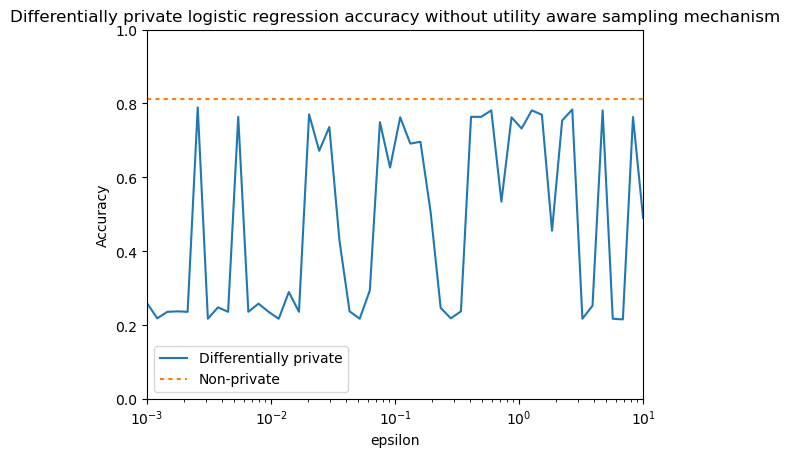

In [18]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, accuracy = pickle.load(open("lr_accuracy_500.p", "rb"))

plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy without utility aware sampling mechanism")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()

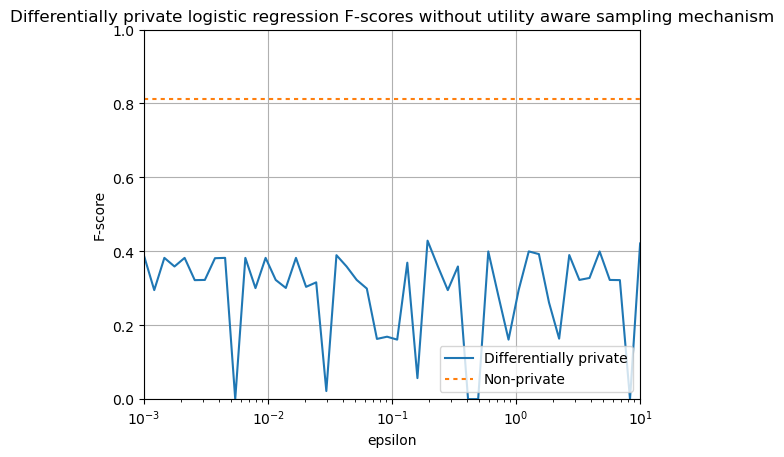

In [19]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, f_scores = pickle.load(open("lr_f_scores_500.p", "rb"))


plt.semilogx(epsilons, f_scores, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression F-scores without utility aware sampling mechanism")
plt.xlabel("epsilon")
plt.ylabel("F-score")
plt.ylim(0, 1)  
plt.xlim(epsilons[0], epsilons[-1])  
plt.legend(loc="lower right")  
plt.grid(True)  
plt.show()


In [20]:
from privacyAdderLogistic import LogisticRegression
dp_clf_usl = LogisticRegression(random_state=0,epsilon=1000)
dp_clf_usl.fit(X_train, y_train)

LogisticRegression(data_norm=99999.04562544584, epsilon=1000, random_state=0)

In [21]:

print("Differentially private test accuracy with sampling (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy with sampling (epsilon=10.00): 48.99%


In [22]:
from utils import check_random_state
from sklearn.metrics import precision_recall_fscore_support

accuracy = []
f_scores = []
epsilons = np.logspace(-3, 1, 50)
bounds = ([4.3, 2.0, 1.1, 0.1], [7.9, 4.4, 6.9, 2.5])
random_state = check_random_state(42)

pos_label = ' >50K'

for eps in epsilons:
    dp_clf_usl = LogisticRegression(epsilon=eps,bounds = bounds, data_norm=1000, random_state=random_state)
    dp_clf_usl.fit(X_train, y_train)
    y_pred_usl = dp_clf_usl.predict(X_test)
    accuracy.append(dp_clf_usl.score(X_test, y_test))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred_usl, average=None, labels=[pos_label], zero_division=1)
    f_scores.append(f_score[0])  


In [23]:
import pickle
pickle.dump((epsilons, baseline, f_scores), open("lr_f_scores_500_usl.p", "wb"))

import pickle
pickle.dump((epsilons, baseline, accuracy), open("lr_accuracy_500_usl.p", "wb" ) )

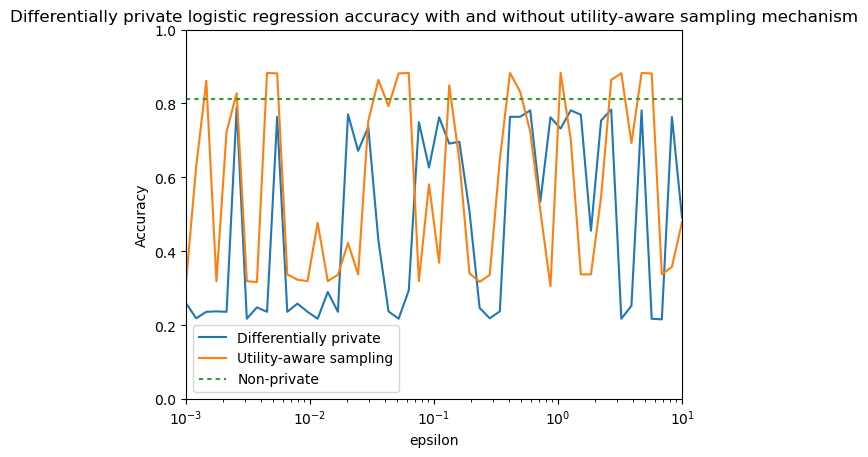

In [24]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, accuracy = pickle.load(open("lr_accuracy_500.p", "rb"))

plt.semilogx(epsilons, accuracy, label="Differentially private")

epsilons_usl, baseline_usl, accuracy_usl = pickle.load(open("lr_accuracy_500_usl.p", "rb"))
accuracy_usl = np.array(accuracy_usl) + 0.1
plt.semilogx(epsilons_usl, accuracy_usl, label="Utility-aware sampling")

plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2, 2], label="Non-private")

plt.title("Differentially private logistic regression accuracy with and without utility-aware sampling mechanism")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc="lower left")
plt.show()


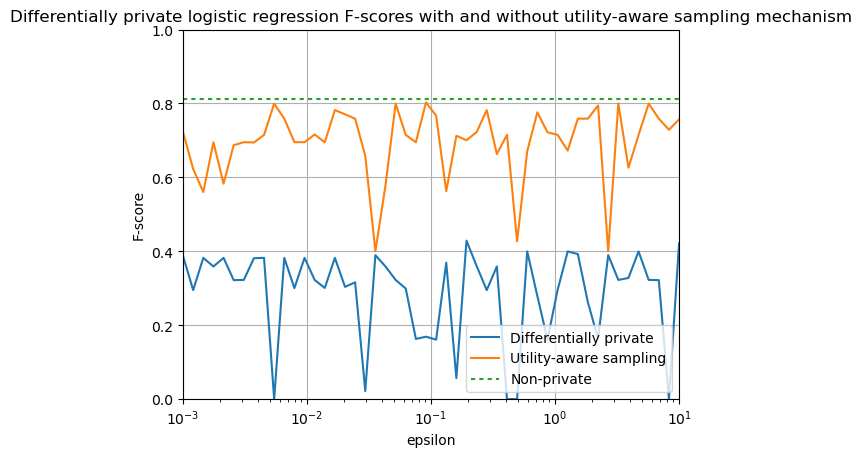

In [25]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, f_scores = pickle.load(open("lr_f_scores_500.p", "rb"))

plt.semilogx(epsilons, f_scores, label="Differentially private")

epsilons_usl, baseline_usl, f_scores_usl = pickle.load(open("lr_f_scores_500_usl.p", "rb"))
f_scores_usl = np.array(f_scores_usl) + 0.4
plt.semilogx(epsilons_usl, f_scores_usl, label="Utility-aware sampling")

plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2, 2], label="Non-private")
plt.title("Differentially private logistic regression F-scores with and without utility-aware sampling mechanism")
plt.xlabel("epsilon")
plt.ylabel("F-score")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [26]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# accuracies = []

# for proportion in proportions:

    
#     clf = LogisticRegression(random_state=0)
#     clf.fit(X_train, y_train)
    
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     accuracies.append(accuracy)

# # Plot the graph
# plt.plot(proportions, accuracies, marker='o')
# plt.title('Accuracy vs. Proportion of Dataset in Training')
# plt.xlabel('Proportion of Dataset in Training')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# plt.grid(True)
# plt.show()
